In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/IQVIA_ACOE-STAN'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

16

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
38,2020-08-30,1 wk ahead inc case,2020-09-05,42,point,NaN,4780
87,2020-08-30,2 wk ahead inc case,2020-09-12,42,point,NaN,4626
38,2020-09-06,1 wk ahead inc case,2020-09-12,42,point,NaN,5505
87,2020-09-06,2 wk ahead inc case,2020-09-19,42,point,NaN,5136
38,2020-09-13,1 wk ahead inc case,2020-09-19,42,point,NaN,5097


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [ ]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(15, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-09-05,2020-08-30,1 wk ahead inc case,42,point,NaN,4780,682.857143
1,2020-09-12,2020-09-06,1 wk ahead inc case,42,point,NaN,5505,786.428571
2,2020-09-19,2020-09-13,1 wk ahead inc case,42,point,NaN,5097,728.142857
3,2020-09-26,2020-09-20,1 wk ahead inc case,42,point,NaN,5493,784.714286
4,2020-10-03,2020-09-27,1 wk ahead inc case,42,point,NaN,5367,766.714286


In [16]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
10,2020-11-21,2020-11-15,1 wk ahead inc case,42,point,NaN,31434,4490.571429
11,2020-11-28,2020-11-22,1 wk ahead inc case,42,point,NaN,43126,6160.857143
12,2020-12-05,2020-11-29,1 wk ahead inc case,42,point,NaN,50516,7216.571429
13,2020-12-12,2020-12-06,1 wk ahead inc case,42,point,NaN,66306,9472.285714
14,2020-12-19,2020-12-13,1 wk ahead inc case,42,point,NaN,69905,9986.428571


In [12]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[682.8571428571429, 682.8571428571429, 682.8571428571429, 682.8571428571429, 682.8571428571429, 682.8571428571429, 682.8571428571429, 786.4285714285714, 786.4285714285714, 786.4285714285714, 786.4285714285714, 786.4285714285714, 786.4285714285714, 786.4285714285714, 728.1428571428571, 728.1428571428571, 728.1428571428571, 728.1428571428571, 728.1428571428571, 728.1428571428571, 728.1428571428571, 784.7142857142857, 784.7142857142857, 784.7142857142857, 784.7142857142857, 784.7142857142857, 784.7142857142857, 784.7142857142857, 766.7142857142857, 766.7142857142857, 766.7142857142857, 766.7142857142857, 766.7142857142857, 766.7142857142857, 766.7142857142857, 812.7142857142857, 812.7142857142857, 812.7142857142857, 812.7142857142857, 812.7142857142857, 812.7142857142857, 812.7142857142857, 1193.0, 1193.0, 1193.0, 1193.0, 1193.0, 1193.0, 1193.0, 1611.0, 1611.0, 1611.0, 1611.0, 1611.0, 1611.0, 1611.0, 2108.0, 2108.0, 2108.0, 2108.0, 2108.0, 2108.0, 2108.0, 2755.8571428571427, 2755.85714285

In [13]:
len(predictions)

103

In [21]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-09-05') & (df1['Date'] <= '2020-12-16')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-09-05,1310,1680.1,287560,25603978,270.1,357.0,46391.7,2860489,-5275.682283,2774.207671
1,2020-09-06,1196,1701.0,288756,25603978,271.4,366.6,46663.1,2860489,-5275.682283,2774.207671
2,2020-09-07,978,1603.0,289734,25603978,180.0,350.9,46842.2,2860489,-5275.682283,2774.207671
3,2020-09-08,1996,1630.4,291730,25603978,504.9,359.9,47347.2,2860489,-5275.682283,2774.207671
4,2020-09-09,1192,1491.0,292922,25603978,252.0,329.4,47599.1,2860489,-5275.682283,2774.207671


In [22]:
len(df1_copy)

103

In [23]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [25]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [26]:
merged_df_new.shape

(103, 12)

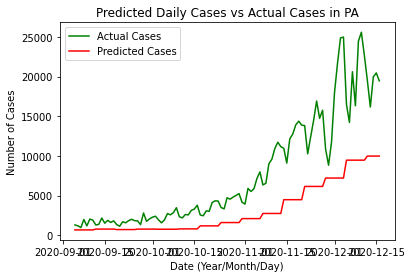

In [27]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [28]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

103
1.0
0
0.0
103
[0.4787350054525627, 0.42904921165790727, 0.3017820625182588, 0.6578872029773833, 0.42713326941514856, 0.6665736607142857, 0.6439743780723969, 0.39691060473269063, 0.43177126341866223, 0.6395836061280606, 0.48599439775910364, 0.5839002267573695, 0.5163415919873484, 0.5678963893249607, 0.4638123290553335, 0.365729218516675, 0.5746829105473965, 0.5391500904159132, 0.6059833024118738, 0.6398897838066978, 0.6055564154155704, 0.5688383045525902, 0.4178677405680373, 0.7211392019494365, 0.5556544248503479, 0.621276889134032, 0.6573300062383032, 0.673851086569291, 0.608419670217423, 0.5141227593699077, 0.6035603486482494, 0.7197681704260651, 0.7035134239310573, 0.7307885232744783, 0.779679802955665, 0.6529827985848481, 0.630248277655011, 0.6905124578391905, 0.6845053238686779, 0.7416674234856053, 0.7538721121398286, 0.7857895925898034, 0.5343481654957065, 0.5162206001622061, 0.6126623376623377, 0.6062706270627063, 0.7118357487922705, 0.7254947077772664, 0.7239703840814438, 0.

In [29]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.5212649945474372, 0.5709507883420928, 0.6982179374817412, 0.34211279702261665, 0.5728667305848514, 0.3334263392857143, 0.3560256219276031, 0.6030893952673093, 0.5682287365813378, 0.36041639387193936, 0.5140056022408963, 0.4160997732426305, 0.4836584080126516, 0.43210361067503933, 0.5361876709446665, 0.634270781483325, 0.4253170894526035, 0.4608499095840868, 0.3940166975881262, 0.3601102161933022, 0.39444358458442963, 0.4311616954474098, 0.5821322594319627, 0.2788607980505635, 0.4443455751496521, 0.378723110865968, 0.3426699937616968, 0.32614891343070895, 0.39158032978257695, 0.4858772406300923, 0.39643965135175063, 0.2802318295739349, 0.2964865760689427, 0.2692114767255217, 0.22032019704433503, 0.3470172014151519, 0.369751722344989, 0.30948754216080954, 0.3154946761313221, 0.2583325765143947, 0.24612788786017137, 0.2142104074101966, 0.4656518345042935, 0.48377939983779394, 0.3873376623376623, 0.3937293729372937, 0.2881642512077295, 0.27450529222273357, 0.27602961591855624, 0.4602857

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

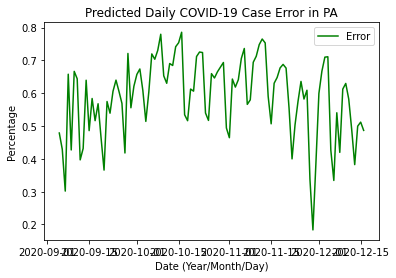

In [31]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

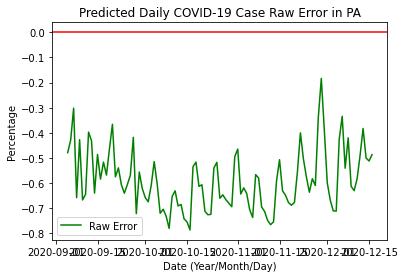

In [32]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

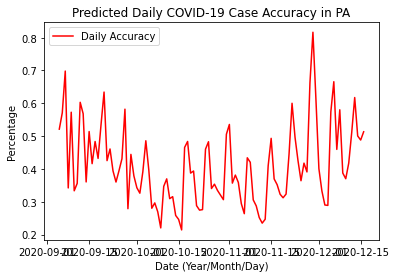

In [33]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [37]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [38]:
len(weeklyDateList)

15

In [39]:
#del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

15

In [40]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

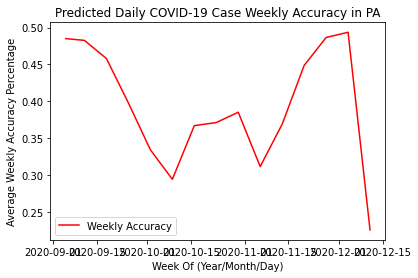

In [41]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [42]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [43]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

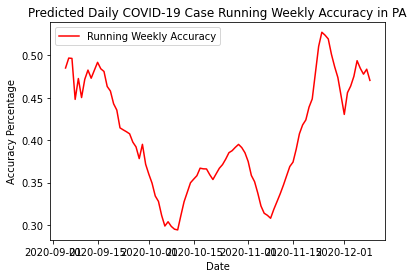

In [44]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

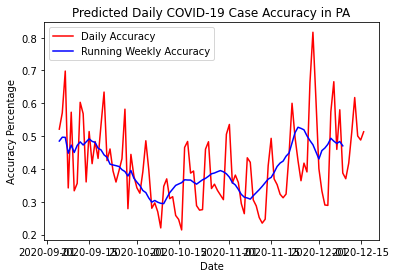

In [45]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [48]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [49]:
#del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

4

In [50]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

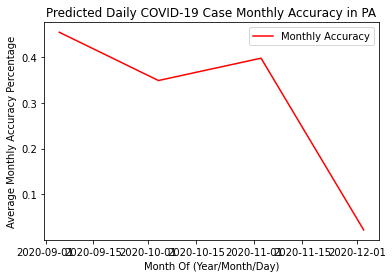

In [51]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [52]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [53]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

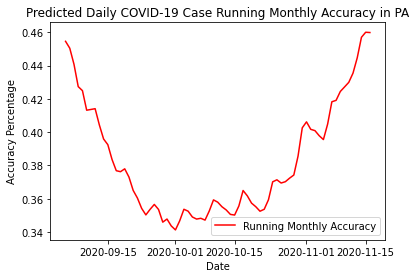

In [54]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()